In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from extreme_classification.extreme_dataset import BivariateLogisticDataset
from extreme_classification.extreme_classifier import ExtremeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_dataset = BivariateLogisticDataset(
    sizes=[5000, 5000],
    alphas=[0.1, 0.5],
    labels=[0, 1],
)

test_dataset = BivariateLogisticDataset(
    sizes=[50000, 50000],
    alphas=[0.1, 0.5],
    labels=[0, 1],
)

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
rf = RandomForestClassifier(n_estimators=200)
extreme_classifier = ExtremeClassifier(model=rf, n_classes=2, n_features=2)

extreme_classifier.fit(train_dataset, k=100)

scores = []
hamming_losses = []

kappas = np.linspace(0.1, 1, 20).astype(np.float32)

for kappa in kappas:
    scores.append(extreme_classifier.score(test_dataset, percentage=kappa))
    hamming_losses.append(extreme_classifier.hamming_loss(test_dataset, percentage=kappa))

In [6]:
from tqdm.notebook import tqdm

rf = RandomForestClassifier(n_estimators=200)
extreme_classifier = ExtremeClassifier(model=rf, n_classes=2, n_features=2)

ks = np.linspace(50, 1000, 5).astype(int)
all_scores = []
all_hamming_losses = []
for k in tqdm(ks):
    print(f"Training with k={k}")
    extreme_classifier.fit(train_dataset, k=k)

    kappas = [
        np.linspace(i, i + 0.09, 50) for i in np.linspace(0.1, 0.9, 10)
    ]

    scores = []
    hamming_losses = []

    for kappa in tqdm(kappas):
        scores.append([extreme_classifier.score(test_dataset, percentage=k) for k in kappa])
        hamming_losses.append([extreme_classifier.hamming_loss(test_dataset, percentage=k) for k in kappa])

    scores = np.array(scores)
    hamming_losses = np.array(hamming_losses)

    all_scores.append(scores)
    all_hamming_losses.append(hamming_losses)


  0%|          | 0/5 [00:00<?, ?it/s]

Training with k=50


  0%|          | 0/10 [00:00<?, ?it/s]

Training with k=287


  0%|          | 0/10 [00:00<?, ?it/s]

Training with k=525


  0%|          | 0/10 [00:00<?, ?it/s]

Training with k=762


  0%|          | 0/10 [00:00<?, ?it/s]

Training with k=1000


  0%|          | 0/10 [00:00<?, ?it/s]

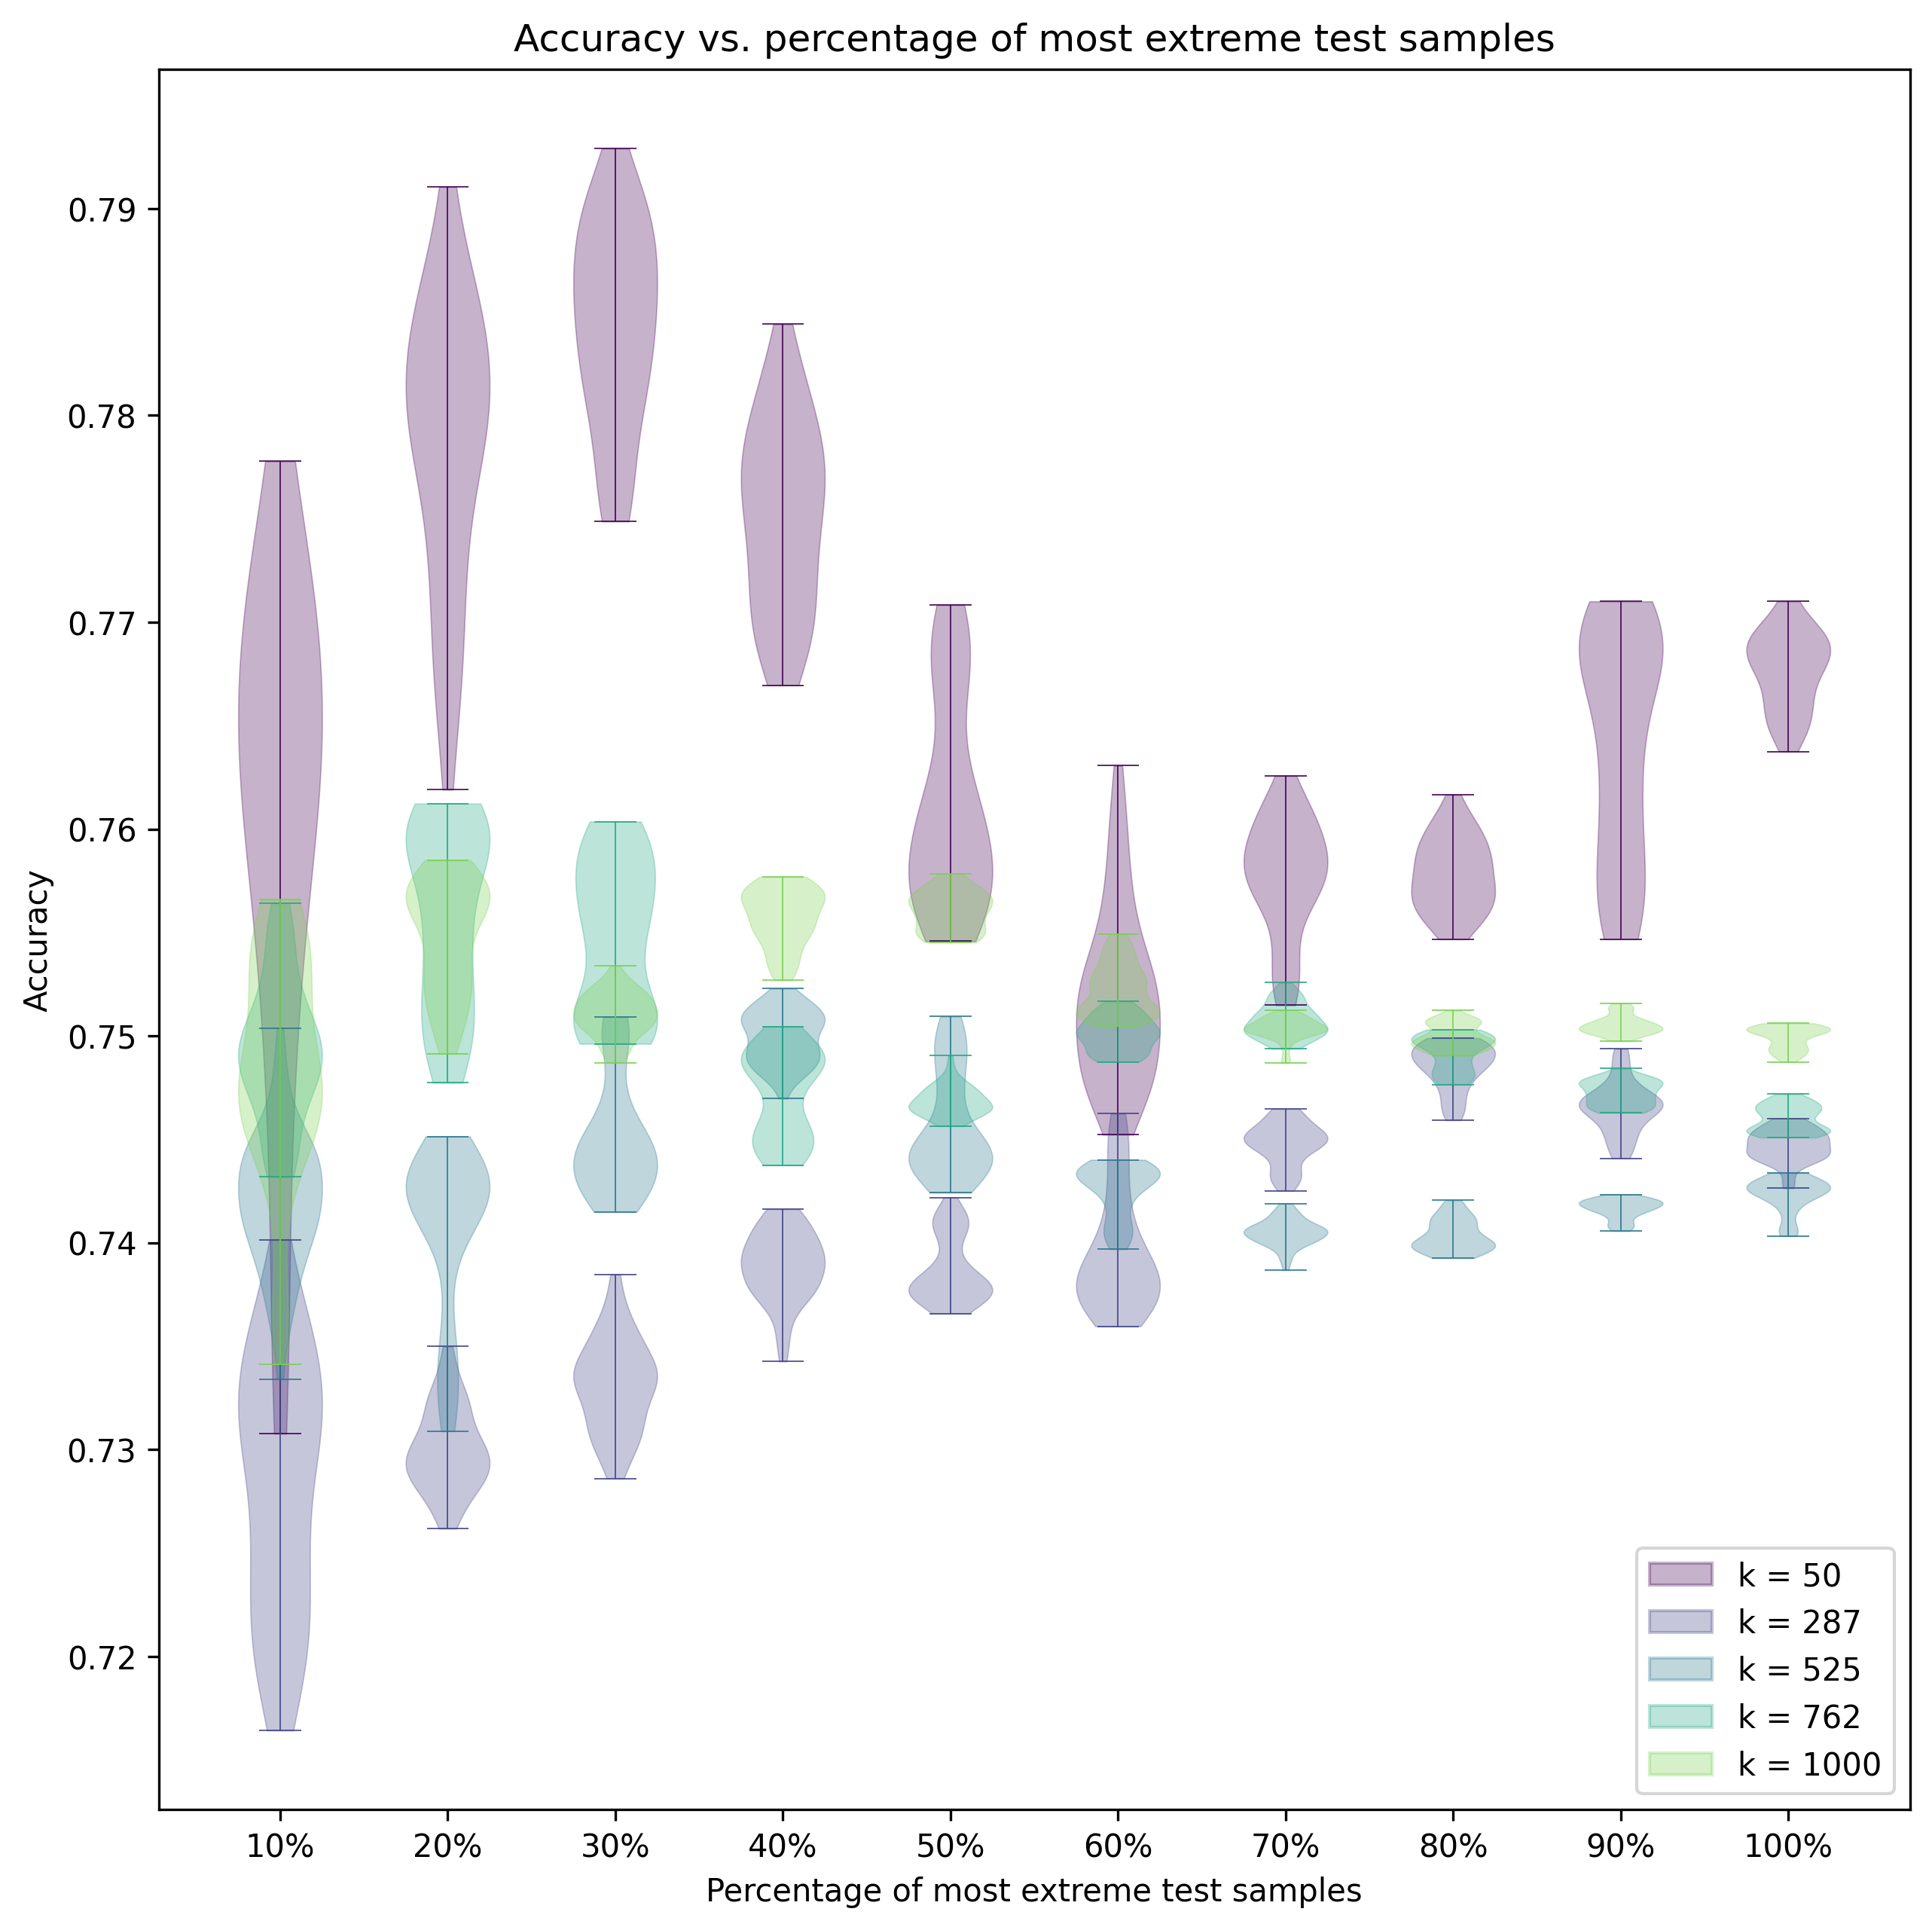

In [7]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10), dpi=300)
colormap = plt.cm.viridis

violins = []
for i, k in enumerate(ks):
    violin = plt.violinplot(list(all_scores[i]))
    for j in range(len(violin["bodies"])):
        violin["bodies"][j].set_facecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_edgecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_linewidth(0.4)
    violin["cmaxes"].set_color(colormap(i / len(ks)))
    violin["cmins"].set_color(colormap(i / len(ks)))
    violin["cbars"].set_color(colormap(i / len(ks)))
    violin["cmaxes"].set_linewidth(0.4)
    violin["cmins"].set_linewidth(0.4)
    violin["cbars"].set_linewidth(0.4)
    violins.append(violin)

plt.legend(handles=[
    mpatches.Patch(color=violin["bodies"][0].get_facecolor(), label=f"k = {k}") for violin, k in zip(violins, ks)
], loc="lower right")
plt.xticks(range(1, 11), map(lambda x: f"{int(x)}%", np.round(np.linspace(10, 100, 10), 1)))
plt.xlabel("Percentage of most extreme test samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. percentage of most extreme test samples")
plt.show()

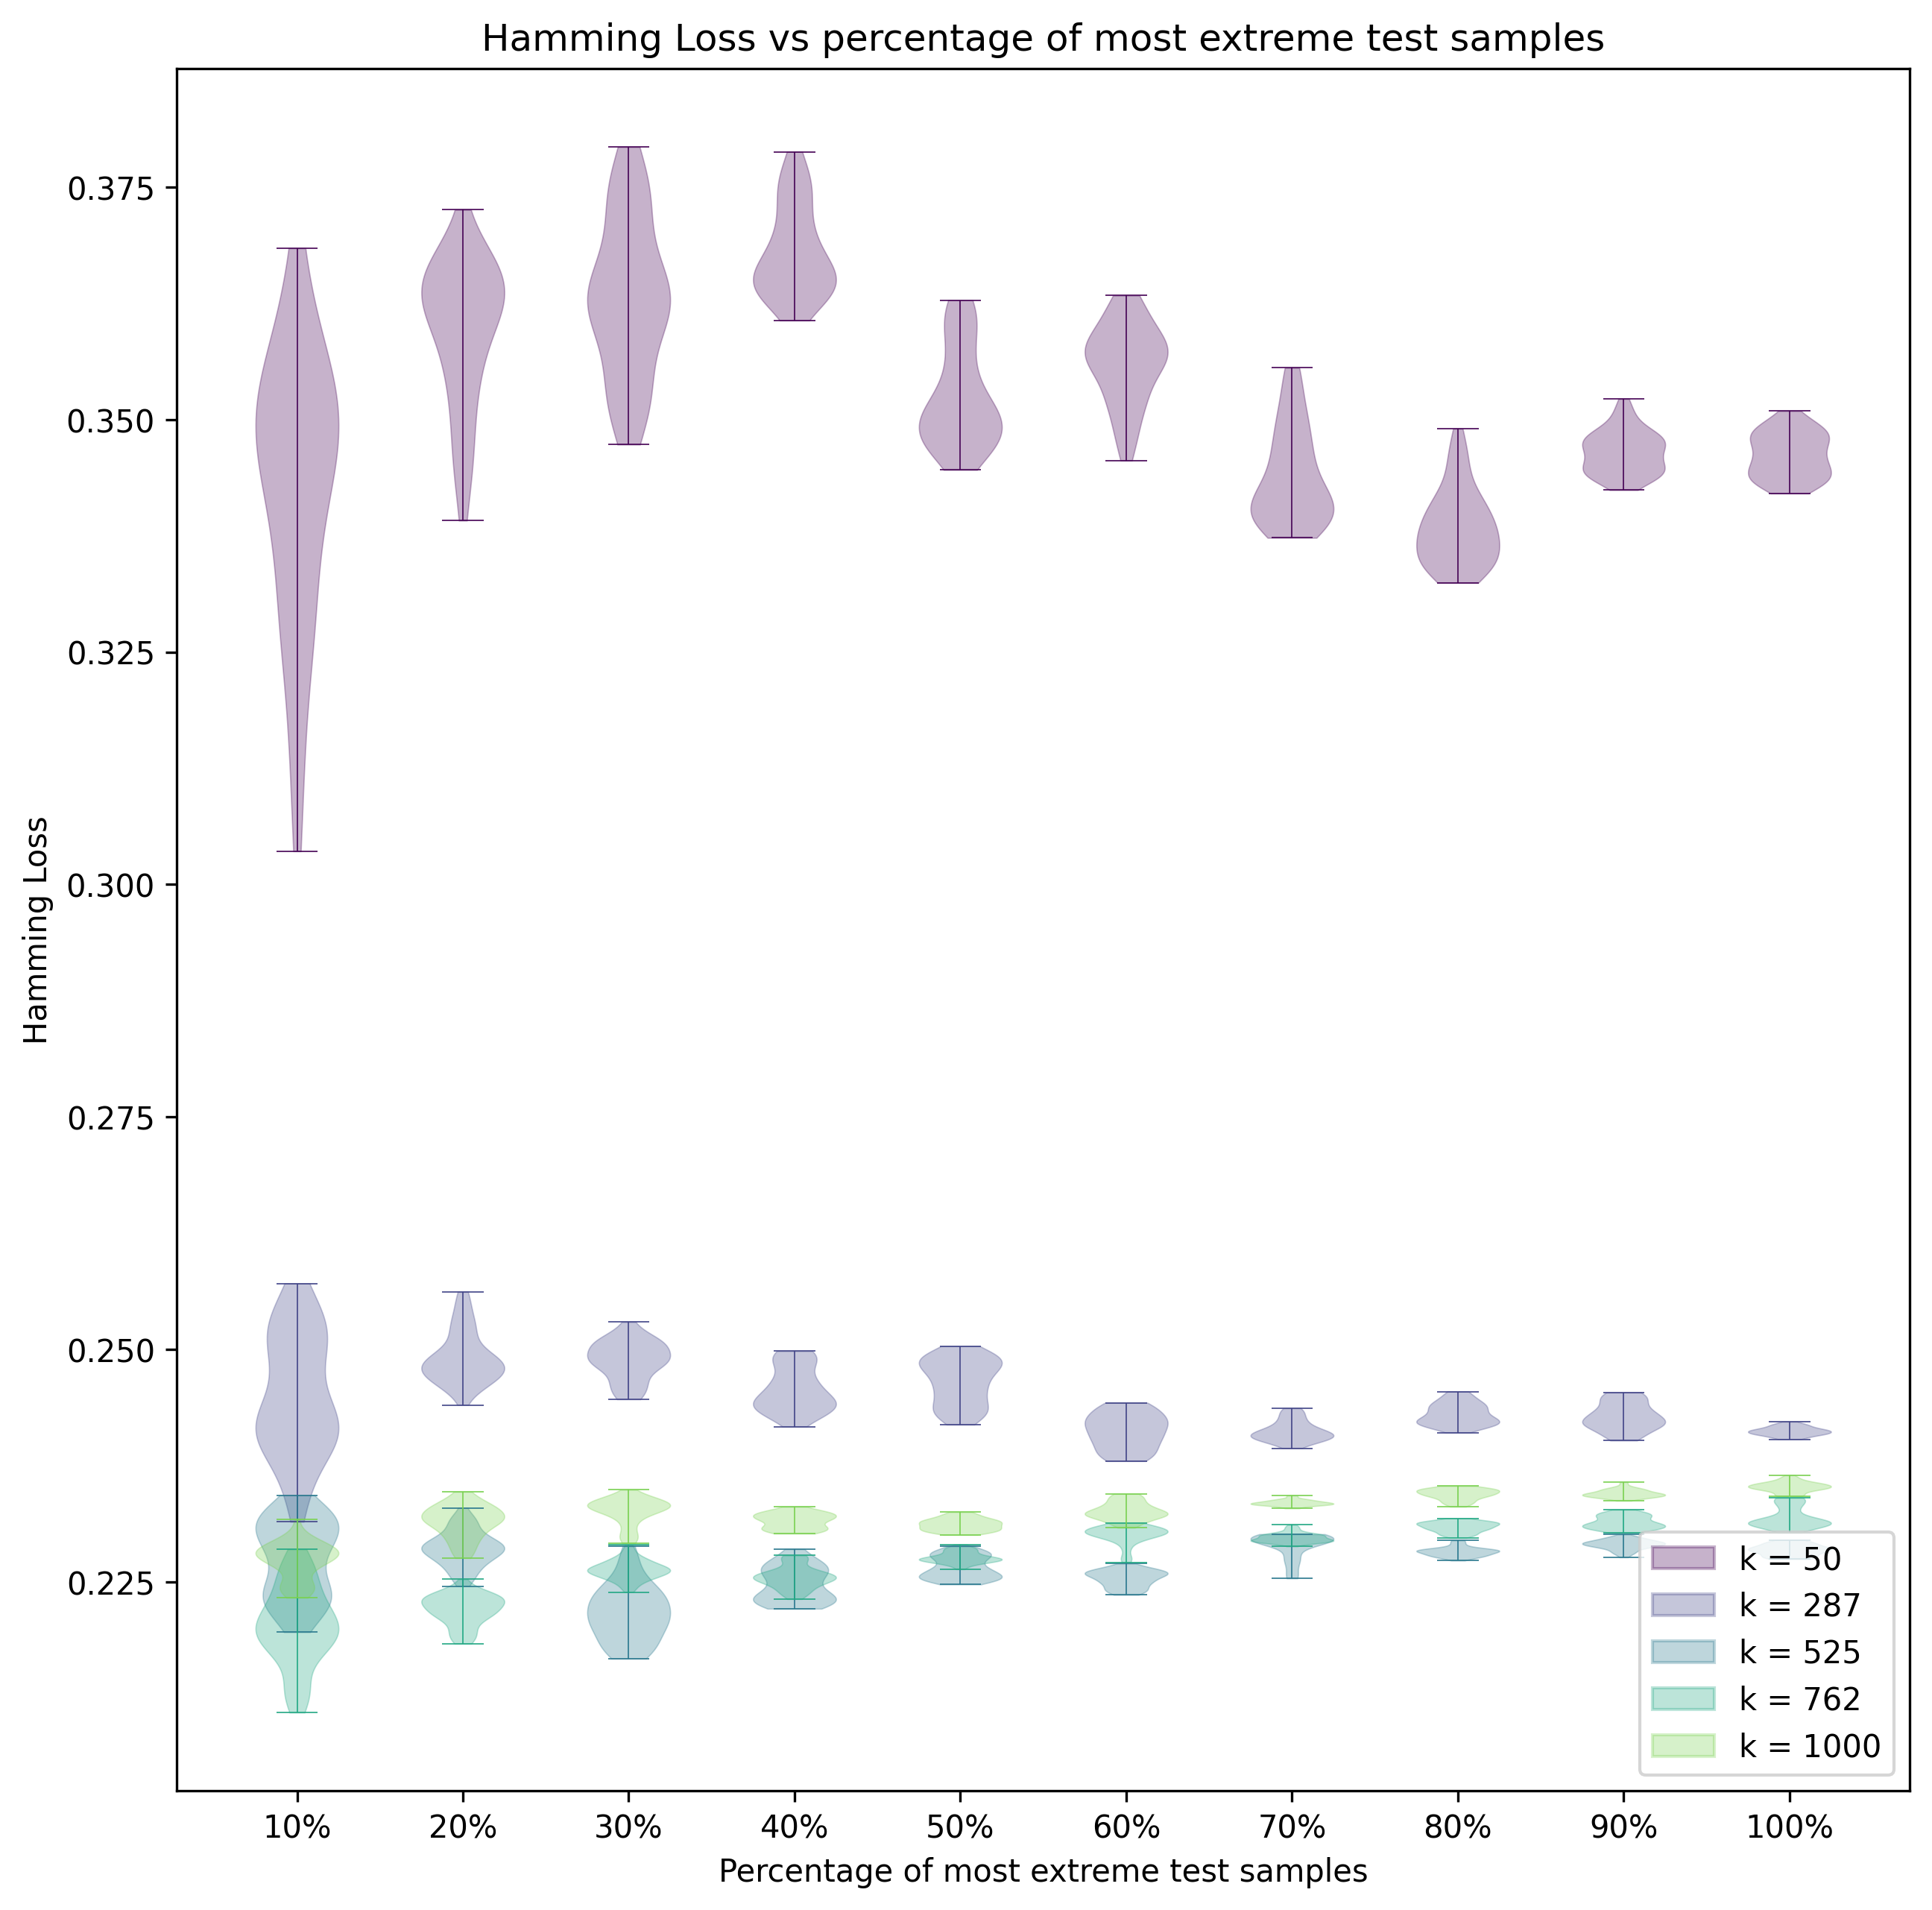

In [11]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10), dpi=300)
colormap = plt.cm.viridis

violins = []
for i, k in enumerate(ks):
    violin = plt.violinplot(list(all_hamming_losses[i]))
    for j in range(len(violin["bodies"])):
        violin["bodies"][j].set_facecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_edgecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_linewidth(0.4)
    violin["cmaxes"].set_color(colormap(i / len(ks)))
    violin["cmins"].set_color(colormap(i / len(ks)))
    violin["cbars"].set_color(colormap(i / len(ks)))
    violin["cmaxes"].set_linewidth(0.4)
    violin["cmins"].set_linewidth(0.4)
    violin["cbars"].set_linewidth(0.4)
    violins.append(violin)

plt.legend(handles=[
    mpatches.Patch(color=violin["bodies"][0].get_facecolor(), label=f"k = {k}") for violin, k in zip(violins, ks)
], loc="lower right")
plt.xticks(range(1, 11), map(lambda x: f"{int(x)}%", np.round(np.linspace(10, 100, 10), 1)))
plt.xlabel("Percentage of most extreme test samples")
plt.ylabel("Hamming Loss")
plt.title("Hamming Loss vs percentage of most extreme test samples")
plt.show()

Text(0.5, 1.0, 'Hamming Loss for different values of kappa')

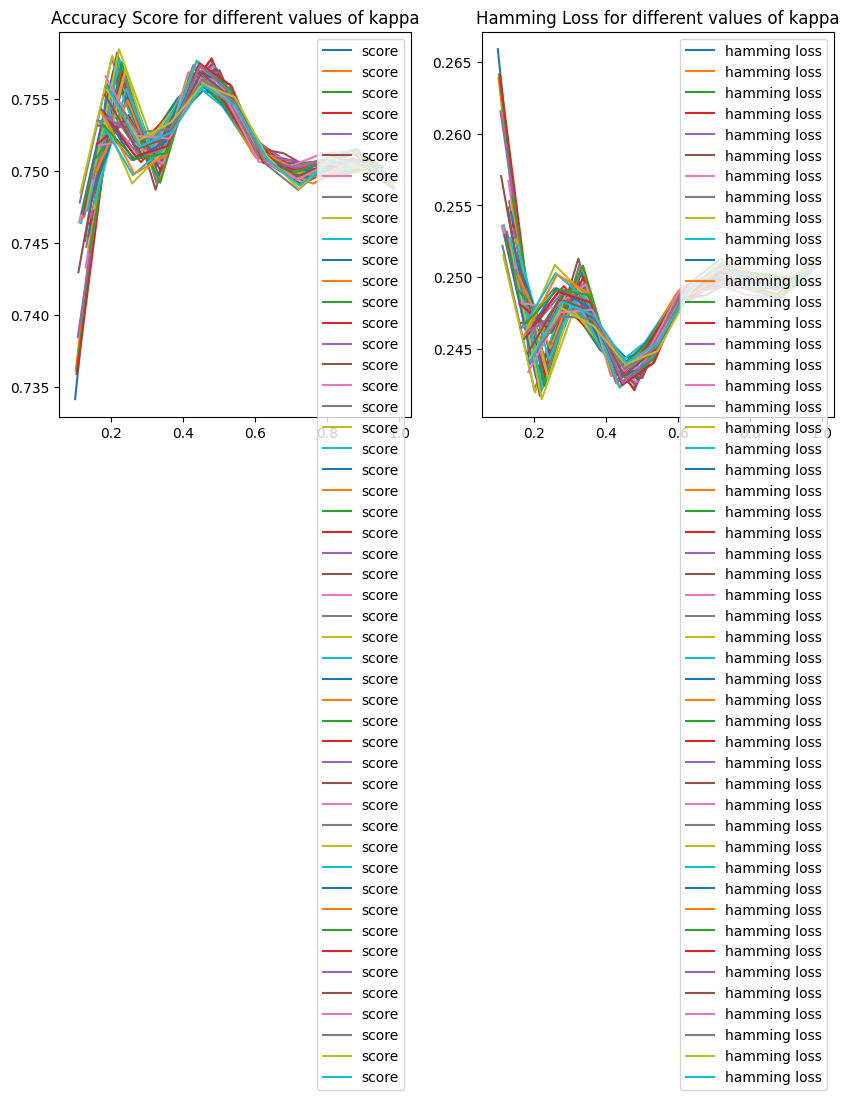

In [8]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(kappas, scores, label="score")
plt.legend()
plt.title("Accuracy Score for different values of kappa")

plt.subplot(1, 2, 2)
plt.plot(kappas, hamming_losses, label="hamming loss")
plt.legend()
plt.title("Hamming Loss for different values of kappa")